# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road**
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below.

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p>
 </figcaption>
</figure>
 <p></p>
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p>
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p>
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**

In [1]:
# Import

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
# from cv2 import cv2
import cv2.cv2 as cv2
%matplotlib inline

This image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


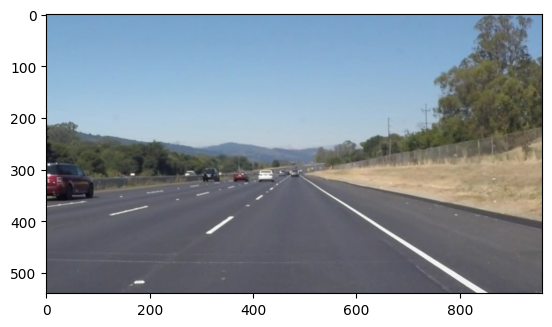

In [2]:
# Reading Images
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Print Statistics
print('This image is: ', type(image), 'with dimensions: ', image.shape)
plt.imshow(image)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection
`cv2.fillPoly()` for regions selection
`cv2.line()` to draw lines on an image given endpoints
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [3]:
import math

In [4]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [5]:
def canny(img, low, high):
    return cv2.Canny(img, low, high)

In [6]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [7]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
def draw_lines(img, lines, color=[255,0,0], thickness=5):
    x_left_lane = []
    y_left_lane = []
    x_right_lane = []
    y_right_lane = []
    ytop = int(350)
    ybtm = int(540)

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = float(((y2-y1)/(x2-x1)))
            if (slope > 0.3):
                x_left_lane.append(x1)
                x_left_lane.append(x2)
                y_left_lane.append(y1)
                y_left_lane.append(y2)

            if (slope < -0.3):
                x_right_lane.append(x1)
                x_right_lane.append(x2)
                y_right_lane.append(y1)
                y_right_lane.append(y2)

    if (x_left_lane != []) & (x_right_lane!=[]) & (y_left_lane!=[]) & (y_right_lane!=[]):
        left_line_coeffs = (np.polyfit(x_left_lane, y_left_lane, 1))
        left_xtop = int((ytop - left_line_coeffs[1])/left_line_coeffs[0])
        left_xbtm = int((ybtm - left_line_coeffs[1])/left_line_coeffs[0])

        cv2.line(img, (left_xtop, ytop), (left_xbtm, ybtm), color, thickness)

        right_line_coeffs = np.polyfit(x_right_lane, y_right_lane, 1)
        right_xtop = int((ytop - right_line_coeffs[1])/right_line_coeffs[0])
        right_xbtm = int((ybtm - right_line_coeffs[1])/right_line_coeffs[0])

        cv2.line(img, (right_xtop, ytop), (right_xbtm, ybtm), color, thickness)

In [9]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [10]:
def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
    return cv2.addWeighted(initial_img, a, img, b, c)

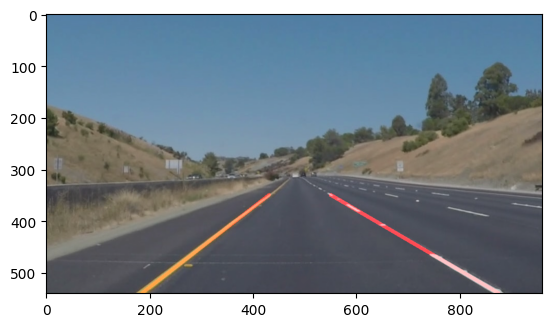

In [11]:
# Test Images

import os
test_images_list = os.listdir("test_images/")

# Build a lane finding pipeline

for test_image in test_images_list:
    image = mpimg.imread('test_images/' + test_image)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    kernel_size = 3
    blur_hls = cv2.GaussianBlur(hls, (kernel_size, kernel_size), 0)
    low = 50
    high = 150
    edges = cv2.Canny(blur_hls, low, high)
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]), (390,350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = cv2.fillPoly(mask, vertices, ignore_mask_color)

    rho = 2
    theta = np.pi/180
    threshold = 20
    min_line_length = 15
    max_line_gap = 25

    masked_edges = region_of_interest(edges, vertices)
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    final_image = weighted_img(line_image, image, a=0.8, b=1.)
    plt.imshow(final_image)
    mpimg.imsave('test_pipeline_images/' + test_image, final_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe.
You can download it by calling:
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    kernel_size = 3
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    blur_hls = cv2.GaussianBlur(hls, (kernel_size,kernel_size), 0)

    low = 50
    high = 150
    edges = cv2.Canny(blur_hls, low, high)
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]), (390,350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = cv2.fillPoly(mask, vertices, ignore_mask_color)

    rho = 2
    theta = np.pi/180
    threshold = 20
    min_line_length = 15
    max_line_gap = 25

    masked_edges = region_of_interest(edges, vertices)
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    final_image = weighted_img(line_image, image, a=0.8, b=1.)
    return final_image

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: total: 15.2 s
Wall time: 25.9 s


In [15]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(white_output))

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: total: 49.3 s
Wall time: 1min 1s


In [17]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(white_output))

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: total: 41.3 s
Wall time: 35.2 s


In [19]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(white_output))